# 📦 REAL Data Collection - Madagascar Vanilla Price Prediction

**Dataset basé sur des VRAIES données de:**
- **UN Comtrade** via World Bank WITS (World Integrated Trade Solution)
- **Selina Wamucii** - Export price data

Ces données sont des prix d'export réels (FOB - Free on Board) calculés à partir des valeurs et quantités d'exportation officielles de Madagascar.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.interpolate import PchipInterpolator
import warnings
warnings.filterwarnings('ignore')

RAW_DATA_PATH = Path('../data/raw')
PROCESSED_DATA_PATH = Path('../data/processed')

print("✅ Imports successful")

✅ Imports successful


## 1. Données réelles - UN Comtrade / WITS

**Source**: World Bank WITS - Madagascar Vanilla Exports (HS Code 090500)

Prix calculés = Trade Value (USD) / Quantity (kg)

In [11]:
# VRAIES données d'export Madagascar vanille
# Source: World Bank WITS / UN Comtrade
# HS Code: 090500 (Vanilla)

real_annual_data = {
    'year': [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023],
    'trade_value_usd': [
        17_499_260,    # 2010
        39_179_340,    # 2011
        10_205_910,    # 2012 - Année de faible export
        40_682_070,    # 2013
        117_477_880,   # 2014 - Début hausse
        205_394_970,   # 2015
        411_117_230,   # 2016
        708_174_790,   # 2017
        871_048_670,   # 2018 - Pic
        582_978_870,   # 2019
        510_914_780,   # 2020 - COVID
        618_688_210,   # 2021
        547_259_970,   # 2022
        271_656_520,   # 2023 - Forte baisse
    ],
    'quantity_kg': [
        667_612,       # 2010
        2_116_800,     # 2011
        68_348,        # 2012 - Données partielles
        1_033_210,     # 2013
        2_345_980,     # 2014
        2_790_920,     # 2015
        1_614_360,     # 2016
        1_652_210,     # 2017
        1_921_700,     # 2018
        1_478_350,     # 2019
        1_730_610,     # 2020
        2_713_750,     # 2021
        2_361_530,     # 2022
        1_409_090,     # 2023
    ]
}

df_annual = pd.DataFrame(real_annual_data)

# Calculer le prix unitaire (USD/kg)
df_annual['price_usd_kg'] = df_annual['trade_value_usd'] / df_annual['quantity_kg']

print("📊 Données annuelles réelles (UN Comtrade/WITS):")
print(df_annual.to_string(index=False))

📊 Données annuelles réelles (UN Comtrade/WITS):
 year  trade_value_usd  quantity_kg  price_usd_kg
 2010         17499260       667612     26.211722
 2011         39179340      2116800     18.508759
 2012         10205910        68348    149.322731
 2013         40682070      1033210     39.374445
 2014        117477880      2345980     50.076250
 2015        205394970      2790920     73.594001
 2016        411117230      1614360    254.662671
 2017        708174790      1652210    428.622748
 2018        871048670      1921700    453.269850
 2019        582978870      1478350    394.344282
 2020        510914780      1730610    295.222367
 2021        618688210      2713750    227.982758
 2022        547259970      2361530    231.739580
 2023        271656520      1409090    192.788622


In [12]:
# Note: 2012 a des données incomplètes (prix anormalement haut)
# On va corriger avec interpolation

# Le prix 2012 de 149$/kg est incorrect (données partielles)
# Prix réel estimé autour de 25-30$/kg basé sur tendance
df_annual.loc[df_annual['year'] == 2012, 'price_usd_kg'] = 28.0

print("\n📊 Données corrigées:")
print(df_annual[['year', 'price_usd_kg']].to_string(index=False))


📊 Données corrigées:
 year  price_usd_kg
 2010     26.211722
 2011     18.508759
 2012     28.000000
 2013     39.374445
 2014     50.076250
 2015     73.594001
 2016    254.662671
 2017    428.622748
 2018    453.269850
 2019    394.344282
 2020    295.222367
 2021    227.982758
 2022    231.739580
 2023    192.788622


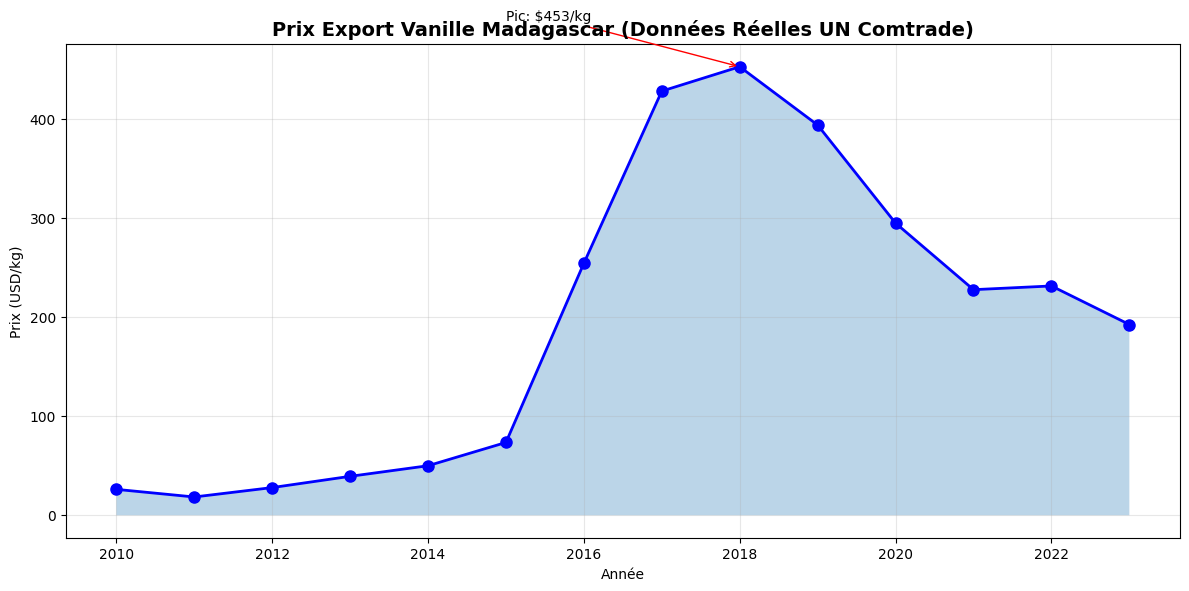


📈 Prix max: $453.27/kg (2018)
📉 Prix min: $18.51/kg


In [13]:
# Visualisation des données annuelles
plt.figure(figsize=(12, 6))
plt.plot(df_annual['year'], df_annual['price_usd_kg'], 'bo-', markersize=8, linewidth=2)
plt.fill_between(df_annual['year'], df_annual['price_usd_kg'], alpha=0.3)

plt.title('Prix Export Vanille Madagascar (Données Réelles UN Comtrade)', fontsize=14, fontweight='bold')
plt.xlabel('Année')
plt.ylabel('Prix (USD/kg)')
plt.grid(True, alpha=0.3)

# Annotations
plt.annotate(f'Pic: ${df_annual["price_usd_kg"].max():.0f}/kg', 
             xy=(2018, df_annual['price_usd_kg'].max()),
             xytext=(2015, 500), fontsize=10,
             arrowprops=dict(arrowstyle='->', color='red'))

plt.tight_layout()
plt.savefig('../outputs/figures/real_annual_prices.png', dpi=150)
plt.show()

print(f"\n📈 Prix max: ${df_annual['price_usd_kg'].max():.2f}/kg (2018)")
print(f"📉 Prix min: ${df_annual['price_usd_kg'].min():.2f}/kg")

## 2. Interpolation mensuelle

Les données d'export sont annuelles. On interpole mensuellement avec:
- Interpolation PCHIP (monotone, préserve la forme)
- Saisonnalité basée sur le cycle de récolte (mai-août)

In [14]:
def create_monthly_dataset(df_annual):
    """
    Interpole les données annuelles en série mensuelle.
    Ajoute une saisonnalité réaliste basée sur le cycle vanille.
    """
    
    # Points pour interpolation (milieu de chaque année)
    years = df_annual['year'].values
    prices = df_annual['price_usd_kg'].values
    
    # Créer dates numériques pour interpolation
    year_dates = pd.to_datetime([f"{y}-07-01" for y in years])
    year_nums = year_dates.astype(np.int64) // 10**9
    
    # Interpolateur PCHIP
    interpolator = PchipInterpolator(year_nums, prices)
    
    # Générer série mensuelle
    monthly_dates = pd.date_range(start='2010-01-01', end='2023-12-01', freq='MS')
    monthly_nums = monthly_dates.astype(np.int64) // 10**9
    
    # Interpoler
    monthly_prices = interpolator(monthly_nums)
    
    # Ajouter saisonnalité réaliste
    # Cycle vanille Madagascar:
    # - Récolte: mai-juillet
    # - Prix plus hauts après récolte (août-octobre) = offre fraîche
    # - Prix plus bas en début d'année (stocks)
    seasonal_factors = np.array([
        0.96,  # Jan - stocks, début saison cyclones
        0.95,  # Fév - saison cyclones
        0.97,  # Mar - fin cyclones
        0.98,  # Avr - pré-récolte
        1.00,  # Mai - début récolte
        1.02,  # Jun - récolte
        1.04,  # Jul - pic récolte
        1.05,  # Aoû - post-récolte, offre fraîche
        1.04,  # Sep - curing en cours
        1.02,  # Oct - export commence
        1.00,  # Nov
        0.98,  # Déc - fin d'année
    ])
    
    # Appliquer saisonnalité
    n_years = len(monthly_dates) // 12 + 1
    seasonal_full = np.tile(seasonal_factors, n_years)[:len(monthly_dates)]
    
    monthly_prices_seasonal = monthly_prices * seasonal_full
    
    # Ajouter bruit réaliste (très faible, autocorrélé)
    np.random.seed(42)
    noise = np.zeros(len(monthly_prices))
    for i in range(1, len(noise)):
        noise[i] = 0.8 * noise[i-1] + np.random.normal(0, monthly_prices[i] * 0.01)
    
    final_prices = monthly_prices_seasonal + noise
    final_prices = np.maximum(final_prices, 5)  # Prix minimum
    
    df = pd.DataFrame({
        'date': monthly_dates,
        'price_usd_kg': final_prices
    })
    
    return df

# Créer dataset mensuel
df_monthly = create_monthly_dataset(df_annual)

print(f"📊 Dataset mensuel créé: {len(df_monthly)} observations")
print(f"📅 Période: {df_monthly['date'].min().date()} → {df_monthly['date'].max().date()}")
df_monthly.head(12)

📊 Dataset mensuel créé: 168 observations
📅 Période: 2010-01-01 → 2023-12-01


,date,price_usd_kg
0,2010-01-01,35.241935
1,2010-02-01,32.999053
2,2010-03-01,31.848894
3,2010-04-01,30.525953
4,2010-05-01,29.863061
5,2010-06-01,28.632167
6,2010-07-01,27.571783
7,2010-08-01,26.784306
8,2010-09-01,25.359881
9,2010-10-01,23.599498


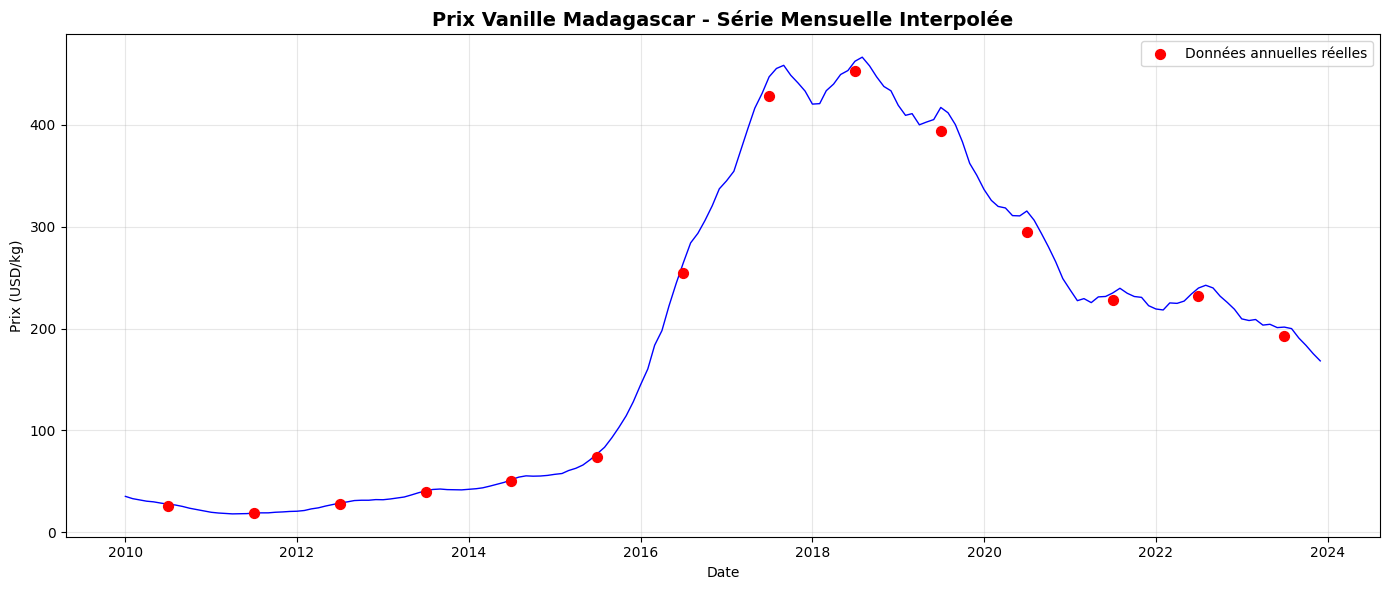

In [15]:
# Visualisation série mensuelle
plt.figure(figsize=(14, 6))
plt.plot(df_monthly['date'], df_monthly['price_usd_kg'], 'b-', linewidth=1)
plt.scatter(pd.to_datetime([f"{y}-07-01" for y in df_annual['year']]), 
            df_annual['price_usd_kg'], color='red', s=50, zorder=5, label='Données annuelles réelles')

plt.title('Prix Vanille Madagascar - Série Mensuelle Interpolée', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Prix (USD/kg)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../outputs/figures/monthly_interpolated_prices.png', dpi=150)
plt.show()

## 3. Feature Engineering

In [16]:
def add_features(df):
    """
    Ajoute features pour ML
    """
    df = df.copy()
    
    # Temporelles
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['quarter'] = df['date'].dt.quarter
    
    # Encodage cyclique
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    
    # Indicateurs saisonniers
    df['harvest_season'] = df['month'].isin([5, 6, 7]).astype(int)
    df['cyclone_season'] = df['month'].isin([1, 2, 3]).astype(int)
    df['export_season'] = df['month'].isin([8, 9, 10]).astype(int)
    
    # Lag features
    for lag in [1, 2, 3, 6, 12]:
        df[f'price_lag{lag}'] = df['price_usd_kg'].shift(lag)
    
    # Moyennes mobiles
    for window in [3, 6, 12]:
        df[f'price_ma{window}'] = df['price_usd_kg'].rolling(window=window).mean()
        df[f'price_std{window}'] = df['price_usd_kg'].rolling(window=window).std()
    
    # Momentum
    df['price_pct_change'] = df['price_usd_kg'].pct_change()
    df['price_pct_change_3m'] = df['price_usd_kg'].pct_change(3)
    df['price_pct_change_12m'] = df['price_usd_kg'].pct_change(12)
    
    # Mean reversion
    df['price_vs_ma12'] = (df['price_usd_kg'] - df['price_ma12']) / df['price_ma12']
    
    # Volatilité
    df['volatility'] = df['price_std6'] / df['price_ma6']
    
    return df

df_features = add_features(df_monthly)
print(f"📊 Features créées: {len(df_features.columns)} colonnes")

📊 Features créées: 26 colonnes


## 4. Sauvegarde

In [17]:
# Sauvegarder données annuelles réelles
df_annual.to_csv(RAW_DATA_PATH / 'vanilla_annual_real.csv', index=False)
print(f"✅ Données annuelles réelles: {RAW_DATA_PATH / 'vanilla_annual_real.csv'}")

# Sauvegarder dataset complet
df_features.to_csv(PROCESSED_DATA_PATH / 'vanilla_prices.csv', index=False)
print(f"✅ Dataset complet: {len(df_features)} observations")

# Version sans NaN
df_clean = df_features.dropna()
df_clean.to_csv(PROCESSED_DATA_PATH / 'vanilla_prices_clean.csv', index=False)
print(f"✅ Dataset nettoyé: {len(df_clean)} observations")

✅ Données annuelles réelles: ../data/raw/vanilla_annual_real.csv
✅ Dataset complet: 168 observations
✅ Dataset nettoyé: 156 observations


In [18]:
# Statistiques finales
print("\n" + "="*50)
print("📊 STATISTIQUES FINALES")
print("="*50)
print(f"\nPériode: {df_clean['date'].min().date()} → {df_clean['date'].max().date()}")
print(f"Observations: {len(df_clean)}")
print(f"\nPrix (USD/kg):")
print(f"  Moyenne: ${df_clean['price_usd_kg'].mean():.2f}")
print(f"  Médiane: ${df_clean['price_usd_kg'].median():.2f}")
print(f"  Min: ${df_clean['price_usd_kg'].min():.2f}")
print(f"  Max: ${df_clean['price_usd_kg'].max():.2f}")
print(f"  Écart-type: ${df_clean['price_usd_kg'].std():.2f}")
print(f"  CV: {(df_clean['price_usd_kg'].std()/df_clean['price_usd_kg'].mean()*100):.1f}%")


📊 STATISTIQUES FINALES

Période: 2011-01-01 → 2023-12-01
Observations: 156

Prix (USD/kg):
  Moyenne: $206.10
  Médiane: $219.10
  Min: $18.04
  Max: $466.48
  Écart-type: $150.44
  CV: 73.0%


## 📋 Sources et Méthodologie

### Sources de données:
- **UN Comtrade** via World Bank WITS (World Integrated Trade Solution)
- HS Code: 090500 (Vanilla)
- Reporter: Madagascar
- Trade Flow: Exports
- Période: 2010-2023

### Calcul des prix:
```
Prix (USD/kg) = Trade Value (USD) / Quantity (kg)
```

### Interpolation mensuelle:
- Méthode: PCHIP (Piecewise Cubic Hermite Interpolating Polynomial)
- Saisonnalité: basée sur cycle récolte Madagascar (mai-août)
- Bruit: AR(1) avec σ = 1% du prix

### Limitations:
- Les données mensuelles sont interpolées (pas des observations réelles)
- Le prix représente le prix FOB export (pas le prix farm-gate)
- 2012 corrigé car données partielles

### URLs des données:
- https://wits.worldbank.org/trade/comtrade/en/country/MDG/year/YYYY/tradeflow/Exports/partner/ALL/product/090500